<a href="https://colab.research.google.com/github/tamburins/ESAA-2022-/blob/main/3_10_ass(127_154).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 3 분류
## 3.1 MNIST
- 고등학생과 미국 인구조사국 직원들의 손글씨 데이터셋으로 각 이미지에는 어떤 숫자를 나타내는지 레이블이 되어있음

- 사이킷런 헬퍼함수를 이용하여 MNIST 데이터셋을 다운받을 수 있음

In [1]:
from sklearn.datasets import fetch_openml
mnist=fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()
     

/usr/local/lib/python3.9/dist-packages/sklearn/datasets/_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

- 사이킷런에서 읽어들인 데이터셋들은 대체로 비슷한 딕셔너리 구조를 가짐

> 데이터셋을 설명하는 DESCR 키

> 샘플이 하나의 행, 특성이 하나의 열로 구성된 배열을 가진 data  키

> 레이블 배열을 담은 target 키


In [2]:
X,y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [3]:
y.shape

(70000,)

- 70000개의 이미지와 각 이미지별 784개의 특성이 있음. 이것은 이미지가 28 X 28 픽셀이기 때문으로 개체의 특성이 단순 흰색(0)부터 검은색(255)까지의 픽셀 강도를 나타냄

- 샘플의 특성벡터를 추출하여 28*28배열로크기를 바꾸고 맷플롯립의 imshow()를 이용하여 데이터셋에서 이미지 하나를 확인해보고자 함

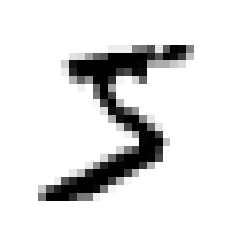

In [4]:
import matplotlib as mlp
import matplotlib.pyplot as plt
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

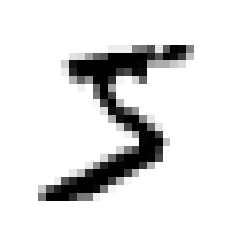

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis('off')
plt.show()


In [6]:
# 숫자 5로 보이는 그림의 레이블 확인
y[0]

'5'

In [7]:
#레이블은 문자열이기 때문에 이를 정수형태로 변환함
import numpy as np
y = y.astype(np.uint8)

In [8]:
# 데이터 조사 전 테스트를 먼저 떼어놓고자 함
# 이미 분리 다 해놨다~
X_train, X_test, y_train, y_test = X[:60000], X[60000:],y[:60000], y[60000:]

- 이미 섞여있는 훈련세트를 이용하여 교차검증 폴드를 만듦

- 특정 학습 알고리즘의 경우 순서에 민감하기 때문에 비슷한 샘플이 연이어 나타날 경우 성능에 부정적인 영향을 끼칠 수 있어 데이터셋을 섞어야 함

## 3.2 이진 분류기 훈련

- 문제를 단순화해서 하나의 숫자(여기에선 5)만 식별해보고자 함

- 이러한 '5 감지기'는 5와 5가 아닌지 클래스를 분류하는 이진 분류기의 예

- 분류 작업을 위한 타깃벡터 생성

In [9]:
y_train_5 = (y_train==5) # 5는 True, 다른 숫자는 모두 False
y_test_5 = (y_test==5)

- 이제 분류모델을 하나 선택하여 훈련시키고자 함

- 사이킷런의 SGDClassifier 클래스를 이용한 확률적 경사하강법을 이용

- 이는 한번에 하나씩 훈련샘플을 독립적으로 처리하기 때문에 온라인 학습에 잘 들어맞아 큰 데이터셋을 효율적으로 처리하는 장점을 가짐

- SGDClassifier 모델을 생성하고 전체 훈련세트를 사용해 훈련해보고자 함

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=4)
sgd_clf.fit(X_train, y_train_5)
# SGDClasifier는 훈련 시 무작위성을 사용하므로, 결과를 그대로 재현하고자 할 경우 random_state 매개변수를 지정해야 함

SGDClassifier(random_state=4)

In [11]:
sgd_clf.predict([some_digit])

array([ True])

- 분류기가 정확히 맞췄으므로 모델의 성능을 평가해보고자 함

## 3.3 성능측정
## 3.3.1 교차 검증을 사용한 정확도 측정
### 교차검증 구현
사이킷런 제공 기능보다 교차검증 과정을 더 많이 제어할 필요가 있을 때 직접 구현하는 코드

In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds =StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train[train_index]
  y_train_folds = y_train_5[train_index]
  X_test_fold = X_train[test_index]
  y_test_fold = y_train_5[test_index]

  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred == y_test_fold)
  print(n_correct / len(y_pred))

0.96835
0.95135
0.9405


cross_val_score 함수를 이용하여 폴드가 3개인 k-겹 교차검증을 사용해 SGDClassifier 모델을 평가해보고자 함 ( k-겹 교차검증은 훈련세트를 k개의 폴드로 나누고 각 폴드에 대해 예측하며 이를 평가하기 위해 나머지 폴드로 훈련시킨 모델을 사용하는 것

In [13]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")


array([0.9695, 0.9675, 0.9628])

95퍼센트 이상의 높은 정확도를 보임. 다음으로 더미분류기를 만들어 비교해보고자 함

In [14]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    return self
  def predict(self, X):
    return np.zeros((len(X), 1), dtype=bool)

모델의 정확도 추측!

In [15]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

정확도가 90퍼 이상으로 이미지의 10퍼센트 정도만 숫자 5이기 때문에 5아님으로만 예측하면 정확히 맞출 확률이 90퍼센트이다.


이러한 이유로 분류기의 성능을 평가할 때 정확도를 선호하지 않으며, 특히 불균형 데이터셋에서 더욱 그렇다.

## 3.3.2 오차행렬
- 분류기의 성능을 평가하는 더 좋은 방법은 오차행렬을 조사하는 것으로 클래스 A의 샘플이 B로 분류된 횟수를 세는 것이다. 예를 들어 5를 3으로 분류한 횟수를 알고싶다면 오차행렬의 5행 3열을 본다.

- 오차 행렬을 생성하기 위해 예측값을 생성한다.

In [16]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)


- cross val score 함수처럼 cross val predict 는 k-겹 교차검증을 수행하지만 평가점수를 반홚지 않고 각 테스트폴드에서 얻은 예측을 반환

- 즉 훈련세트의 모든 샘플에 대해 꺠끗한-모델이 훈련하는동안 보지 못했던 데이터에 대한 예측을 한-예측을 획득

- confusion_matrix 함수를 사용하여 오차행렬을 만들 준비 완료, 타깃 클래스 y_train_5와 예측클래스(y_train_pred)를 넣고 호출



In [17]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53729,   850],
       [ 1154,  4267]])

- 오차행렬의 행이 실제 클래스, 열은 예측한 클래스로 각각 왼쪽위부터 오른쪽 위 순으로 1,2,3,4를 칭할 때 1행은 5아님으로 분류한 것(음성클래스)으로 1행 1열은 진짜 음성, 1행 2열은 가짜 음성, 2행은 양성클래스에 대한 것으로 2행 1열은 5를 5가 아니라고 분류한 것(거짓 음성)2행 2열은 진짜양성(정확히 5인 것)을 의미


In [18]:
y_train_perfect_predictions = y_train_5 # 완벽한 분류기의 경우
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

- 오차행렬이 아닌 요약된 지표가 필요할 경우 사용하는 정밀도는 양성 예측의 정확도로 

  TP / ( TP + FP)

  이 때 TP는 진짜 양성, FP는 가짜 양성을 의미

- 재현율, 혹은 민감도, 진짜양성비율

  TP / ( TP + FN )

  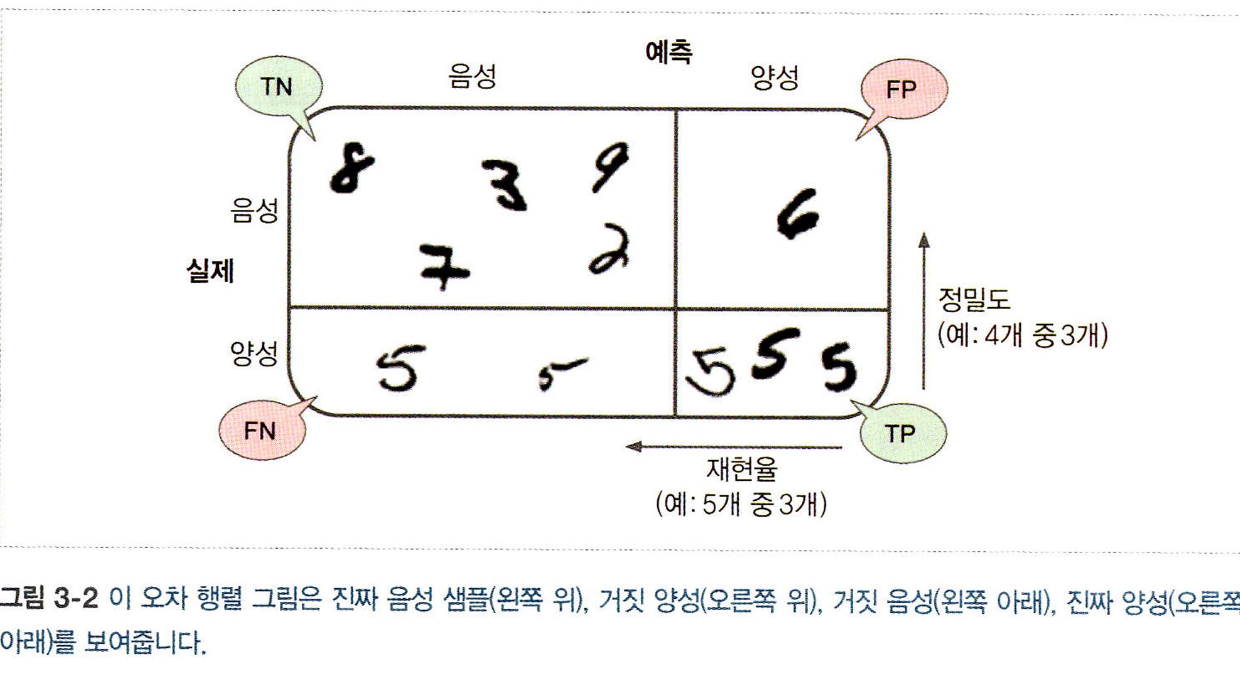



## 3.3.3 정밀도와 재현율


In [19]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) # == 4096/(4096 + 1522)

0.8338870431893688

In [20]:
recall_score(y_train_5,y_train_pred) # == 4096/(4096 + 1325)

0.7871241468363771

총 73퍼센트정도만 정확한 것으로 전체 숫자5에서 76퍼센트만 감지

정밀도와 재현율울 함께 보기위해 F1점수로 같이 만들면 두 분류기를 비교할 때 편리함

F1점수는 정밀도와 재현율의 조화평균으로

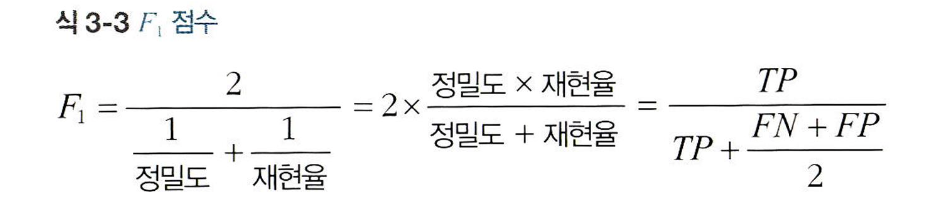

In [21]:
#calculating f1score
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.8098310874928828

- 정밀도와 재현율이 비슷한 분류기에서는 F1점수가 높으나 이것이 항상 바람직한 것은 아님

- 예를 들어 어린이에게 안전한 동영상을 걸러내는 분류기를 훈련시킨다 가정하면, 재현율은 높으나 정말 나쁜 동영상이 몇개 노출되는것보다 좋은 동영상이 많이 제외되더라도(낮은 재현율) 안전한 것들만 노출시키는 ( 높은 정밀도) 분류기를 선호할 것

- 감시카메라로 좀도둑을 잡아내는 분류기를 훈련시킨다고 가정한다하면 분류기 재현율이 99퍼라면 정확도가 30퍼센트만 되더라도 괜찮을지 모름

- 이렇게 한가지를 올리면 한가지가 떨어지는 것을 정밀도/재현율 트레이드 오프라 함

## 3.3.4 정밀도/재현율 트레이드 오프

- SGDClassifier는 결정함수를 통해 각 샘플의 점수를 계산한 후 임계값보다 점수가 크면 양성클래스에, 반대에 음성클래스에 할당

- 결정임계값을 높이면 정밀도가 높아지지만 재현율이 낮아지고, 결정임계값을 낮추면 정밀도가 낮아지면서 재현율이 높아짐

- 사이킷런에서 임계값을 직접 지정은 불가하나, 사용한 점수는 확인할 수 있음 bv decision function method

In [22]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([1570.91971558])

In [23]:
threshold=0
y_some_digit_pred =(y_scores > threshold)

In [24]:
#SGDClassifier의 임계값이 0이므로 위 코드는 predict와 같은 결과를 반환
# 임계값 높이면?
threshold = 8000
y_some_digit_pred= ( y_scores > threshold)
y_some_digit_pred

array([False])

위 결과는 임계값을 높이면 재현율을 줄일 수 있다는 것을 보여줌


적절한 임계값을 구하기 위해서는 cross_val_predict를 이용하여 훈련세트에 있는 모든 샘플의 점수를 구해야 하나 이번에는 예측결과가 아니라 결정점수를 반환받도록 지정해야 함


In [25]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5,cv=3,
                             method="decision_function")
#wiht precision_recall_curve function

In [26]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)


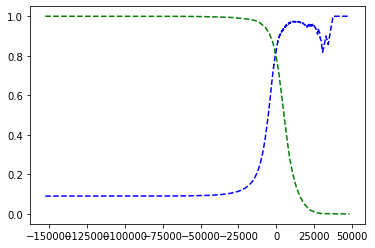

In [27]:
#with matplotlib, draw 정밀도와 재현율 with 임곗값의 함수
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], 'b--', label="정밀도")
  plt.plot(thresholds, recalls[:-1], 'g--', label="재현율")
  [...] #임곗값을 표시하고 범례, 축이름, 그리드를 추가합니다

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()



- 좋은 정밀도/재현율 트레이드 오프를 선택하는 방법은 정밀도 곡선을 그린 뒤 급격하게 재현율이 떨어지는 지점을 찾아 하강점 직전을 정밀도/재현율 트레이드 오프로 선택하는 것이 좋음

- 정밀도 90퍼를 달성하는 것이 목표의 경우 임곗값이 약 8000정도임을 알 수 있으며 조금 더 정확히 최소 90퍼 정밀도가 되는 가장 낮은 임곗값을 찾을 수 있음

In [28]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [29]:
#훈련세트에 대한 예측 생성을 위해 predict 메서드 대신 코드실행
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [30]:
# check precision score and recall_score for this predict
precision_score(y_train_5, y_train_pred_90)

0.9000480538202787

In [31]:
recall_score(y_train_5, y_train_pred_90)

0.6910164176351227

## 3.3.5 ROC 곡선

수신기 조작 특성(ROC)곡선이란 거짓양성 비율에 대한 진자 양성 비율의 곡선으로 양성으로 잘못 분류된 음성 샘플의 비율 FPR 대비 진짜음성비율로 진짜음성비율 TNR을 특이도라고도 하며, ROC곡선을 따라서 민감도(재현율)에 대한 1-특이도 그래프라 할 수 있음

In [32]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

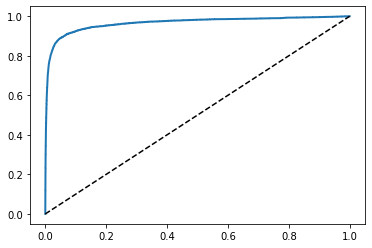

In [33]:
def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0,1],[0,1],'k--')#대각 점선
  # 축이름 , 그리드는 셀프
plot_roc_curve(fpr, tpr)
plt.show()

재현율이 높을수록 분류기가 만드는 거짓양성이 늘어나므로 좋은 분류기는 점선에서 멀리 떨어져있어야 함

- 곡선 아래의 면적(AUC)를 측정하면 분류기들을 비교할수 있는데, 완벽한 분류기는 ROC 의 AUC가 1이고 완전한 랜덤분류기는 0.5

In [34]:
#sklearn ROC's AUC calculating function
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9652964469094635

- 양성클래스가 드물거나 거짓음성보다 거짓 양성이 더 중요할 때 PR 곡선, 그렇지 않으면 ROC곡선을 사용함

- RandomForestClassifier를 훈련시켜 SGDClassifier 의 ROC곡선과 ROC AUC 점수를 비교하고자 함

- 작동방식의 차이로 랜포의 predict_proba메서드를 이용하고자 함

- 사이킷런 분류기는 predict proba, dedcision funtion 둘 중 하나 혹은 둘을 모두 가짐

- predictP_proba 메서드는 샘플이 행, 클래스가 열이고 샘플이 주어진 클래스에 속할 확률을 담은 배열을 반환



In [35]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [36]:
# roc_curve 함수에서 점수 대신 클래스 확률 전달받기
y_scores_forest = y_probas_forest[:,1]#양성클래스에 대한 확률을 점수로 사용
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

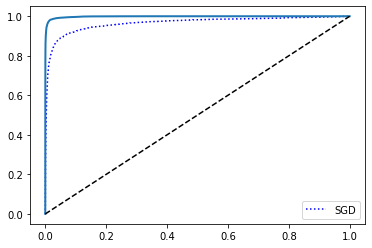

In [37]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest)
plt.legend(loc="lower right")
plt.show()

In [38]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

#3.4 다중분류

- 다중분류기, 혹은 다항분류기는 둘 이상의 클래스를 구분하는 것으로 직접 여러개의 클래스를 처리하는 방법과 이진분류기의 다중 사용으로 이를 구현하는 것도 있음

- 특정 숫자 하나만 구분하는 숫자별 이진분류기 10개를 훈련시켜 클래스가 10개인 숫자이미지 분류 시스템을 만들 수 있는데, 이미지를 분류할 때 각 분류기의 결정점수 중에서 가장 높은 것을 클래스로 선택하면 됨 > 이를 OvR, OvA라 칭함

- 또 다른 전략은 0,1구별, 0,2구별, 1,2구별 같이 각 숫자 조합마다 이진 분류기를 훈련시키는 것으로 이를 OvO전략이라 하나ㅏ 클래스가 n개의 경우 n*(n-1)/2개의 분류기가 필요함. 이는 각 분류기의 훈련에 대해 전체 훈련세트 중 구별할 두 클래스에 해당하는 샘플만 필요하다는 것

- 일부 알고리즘은 훈련세트 크기에 민감하여 훈련세트 큰 곳에서 몇개의 분류기를 훈련시키는 것보다 작은 훈련세트에서 많은 분류기를 훈련시키는 쪽이 빠르므로 Ovo를 선호하나 대부분은 OvR을 선호

- 다중 클래스 분류에서 이진 분류알고리즘을 선택하면 사이킷런이 알고리즘에 따라 자동으로 OvR, OvO를 실행함

In [39]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

사이킷런이 OvO전략을 사용해 10개의 이진분류기를 훈련시키고 각각 결정점수를 얻어 점수가 가장 높은 클래스를 선택

확인해보자!

In [40]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [41]:
np.argmax(some_digit_scores)

5

In [42]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [43]:
svm_clf.classes_[5]

5

사이킷런에서 OvO or OvR을 사용하도록 강제하려면 OneVsOneClassifier나 OneVsRestClassifier를 사용해야 함


In [44]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf. predict([some_digit])
len(ovr_clf.estimators_)

10

In [45]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5], dtype=uint8)

In [46]:
# check score which SGDClassifier assign
sgd_clf.decision_function([some_digit])

array([[-29316.625741  , -50073.27452728, -14334.80485445,
           152.26145685, -18108.04151303,   3731.72734972,
        -27260.59393028, -21998.08028979,  -7979.87344512,
         -6067.36588281]])

In [47]:
# evaluate classifier with cross val score
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.86955, 0.868  , 0.87455])

In [48]:
# more than 84%, get highter ability
from sklearn.preprocessing import StandardScaler
scaler =StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


array([0.89985, 0.89505, 0.90465])

#3.5 에러 분석
성능 향상 방법 중 하나는 에러의 종류를 분석하는 것으로 그 중 cross_val_predict를 이용하여 예측을 만들고 confusion matrix 함수를 호출하여 오차행렬을 살펴볼 수 있음

In [49]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


array([[5587,    0,   23,    5,    9,   48,   36,    6,  208,    1],
       [   0, 6409,   38,   25,    4,   44,    4,    8,  199,   11],
       [  27,   27, 5248,   94,   72,   28,   66,   40,  346,   10],
       [  23,   18,  119, 5242,    2,  214,   27,   41,  374,   71],
       [  12,   14,   49,   10, 5209,   12,   36,   25,  309,  166],
       [  27,   16,   34,  171,   54, 4480,   78,   16,  486,   59],
       [  30,   16,   45,    2,   42,   98, 5559,    3,  122,    1],
       [  21,   11,   53,   29,   51,   13,    3, 5707,  171,  206],
       [  18,   65,   47,   89,    3,  127,   25,   10, 5422,   45],
       [  26,   19,   29,   65,  116,   39,    1,  181,  345, 5128]])

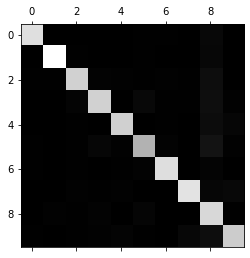

In [50]:
# with matshow function, express image
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

숫자 5가 다른 숫자에비해 어두운 것을 통ㅇ해 숫자5가 적거나 분류기가 다른 숫자에 비해 5를 잘 분류하지 못하는 것으로 확인

이를 확인해보자!


그래프의 에러에 초점을 맞춰 오차행렬의 각 값을 대응되는 클래스의 이미지개수로 나누어 에러 비율을 비교함

In [51]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx/row_sums

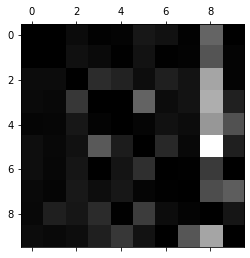

In [52]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()


분류기가 만든 에러를 보았을 때 클래스 8의 열이 상당히 밝으므로 상당히 많은 이미지가 9로 잘못 분류되었음을 암시하나 8행은 나쁘지 않으며, 3,5가 서로 혼동되는 것을 알수 있음

이를 통해 8로 잘못 분류되는 것을 줄이도록 개선할 필요가 있다는 것을 알 수 있으므로 8 훈련 데이터를 많이 모아 학습시킬 수 있으며 분류기에 도움될만한 특성을 더 찾아 - 예를 들어 동심원의 수를 세는 알고리즘, 혹은 패턴 찾는 이밎 ㅣ전처리-개선시킬 수 있음

개개의 에러를 분석하면 이에 대한 통찰을 얻을 수 있으나 시간이 매우 오래걸리고 어려움

In [ ]:
cl_a, cl_b=3,5
X_aa=X_train[(y_train ==cl_a)&(y_train_pred==cl_a)]
X_ab=X_train[(y_train ==cl_a)&(y_train_pred==cl_b)]
X_ba=X_train[(y_train ==cl_b)&(y_train_pred==cl_a)]
X_bb=X_train[(y_train ==cl_b)&(y_train_pred==cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

분류기가 잘못 분류한 숫자는 정말 사람도 분류하기 어려운 잘못된 숫자도 있으나 대부분 이해하기 어려운 것으로 이는 선형 모델인 SGDClassifier를 사용했기 때문으로, 선형분류기는 클래스마다 픽셀에 가중치를 할당하고 새 이미지에 대해 단순히 픽셀 강도의 가중치합을 클래스 점수로 계산하기 때문에 혼동이 쉬움

- 3,5의 주요 차이는 위족 선과 아래 호를 이어주는 작은 직선의 위치로 3을 쓸 때 연결부위가 왼쪽으로 치우치면 5로 분류하고 반대도 마찬가지로 이미지의 위치나 회전방향에 매우 민감하므로 중앙에 위치시키고 회전되어있지 않도록 전처리하는 것

#3.6 다중 레이블 분류
각 샘플이 하나의 클래스에만 할당되었다면 분류기가 샘플별로 여러 클래스를 출력해야할 때도 있음 > 여러개의 이진 꼬리표를 출력하는 분류시스템을 다중레이블 분류시스템이라 함

In [55]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train>= 7 )
y_train_odd = (y_train % 2 ==1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)


KNeighborsClassifier()

In [56]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [57]:
#evaluate multi label classifier
# with F1 score
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

모든 레이블의 가중치가 같다는 가정하에 진행하였으며 정보가 불균형할 경우 지지도에 가중치를 두어 개선 가능( by average =" weighted'로 지정)



# 3.7 다중 출력 분류
다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화한 다중 출력 다중 클래스 분류를 생성하기 위해서는 이미지의 잡음을 제거해야함

먼저 MNIST 이미지에서 추출한 훈련세트와 테스트셍트에 넘파이의 randint()함수를사용하여 픽셀강도에 잡음을 추가함

In [58]:
noise = np.random.randint(0,100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0,100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [ ]:
# clear image by training classifier
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)